# Machine Learning 2 - Classifying images of microstructure

In [1]:
# Import some modules that we will require
import numpy as np  
import scipy as sp
import cv2 # This is an image processing module
import sklearn # This is a module of machine learning tools

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

## Introduction
We thought it might be fun to use our new-found knowledge of machine learning to tackle a real, current research problem. A hot-topic in materials science, both in academia and industry, is how we might make use of machine learning and the tools of Big Data in discovering new materials. An important challenge in this field is how we deal with the sort of data that we get from experiments, which can be noisy and shows large variations. In this notebook we will show how the tools in scikit-learn allow us to automatically classify images of microstructures of different types.

The method we will use is taken from a recent research article:

![Paper header](Images/DecostHolmHeader.jpg "Title")

I have implemented it especially for this course. You can read more about it in the original paper, but I will also describe it briefly below. It's a bit involved, but bear with me and it should become clearer as we work through the notebook.

## The method 

The method works as follows:

1. We begin with a set of micrographs covering the range of microstructures we wish to distinguish.
2. We use a commonly used image *descriptor* to detect features of interest in this set of images.
3. We use an *unsupervised* learning method to detect distinct clusters of these descriptors. The centres of these clusters then form the "words" in a visual dictionary that we can use to describe images of micorstructure.
4. We now return to our set of micrographs, but this time we assign them to different classes. 
5. For each micrograph, we apply the image descriptor to find the features of interest and classify them according to our previously determined clusters. Each feature is thus assigned to a given "word" within our visual dictionary.
6. For each micrograph we now count up the occurances of each word. The histogram of word frequency becomes the visual "fingerprint" of the micrograph.
7. We now use a *supervised* learning method to train a classifier to relate the fingerprints of our training set to the classes of microstructure.
8. We test and evaluate the performance of our classifier on an unseen test sample of micrographs.

Now let's see how this works out in practice.....

## Step 1: Some images to work with
To keep things simple we will stick to a binary classification between two types of microstructure: a super-alloy type and a basket-weave microstructure. I have grabbed a series of suitable images from the internet. The first thing to do is build a list of the images for the training and test samples:

In [2]:
folders = ['BasketWeave','Superalloy']
ninfolder = [11,9]
folderstub = ['BW', 'SA']
ntest = [3,3]
nfoldersuse = 2

files = []
folderid = []
for s in range(nfoldersuse):
    for t in range(ntest[s],ninfolder[s]):
        files.append('Micrographs/' + folders[s] + '/' + folderstub[s] + str(t+1) + '.jpg')
        folderid.append(s)
nfiles = len(files)

testfiles = []
testfolderid = []
for s in range(nfoldersuse):
    for t in range(ntest[s]):
        testfiles.append('Micrographs/' + folders[s] + '/' + folderstub[s] + str(t+1) + '.jpg')
        testfolderid.append(s)
ntestfiles = len(testfiles)

Let's take a look at the training set (look in the folder if you wish to view the others):

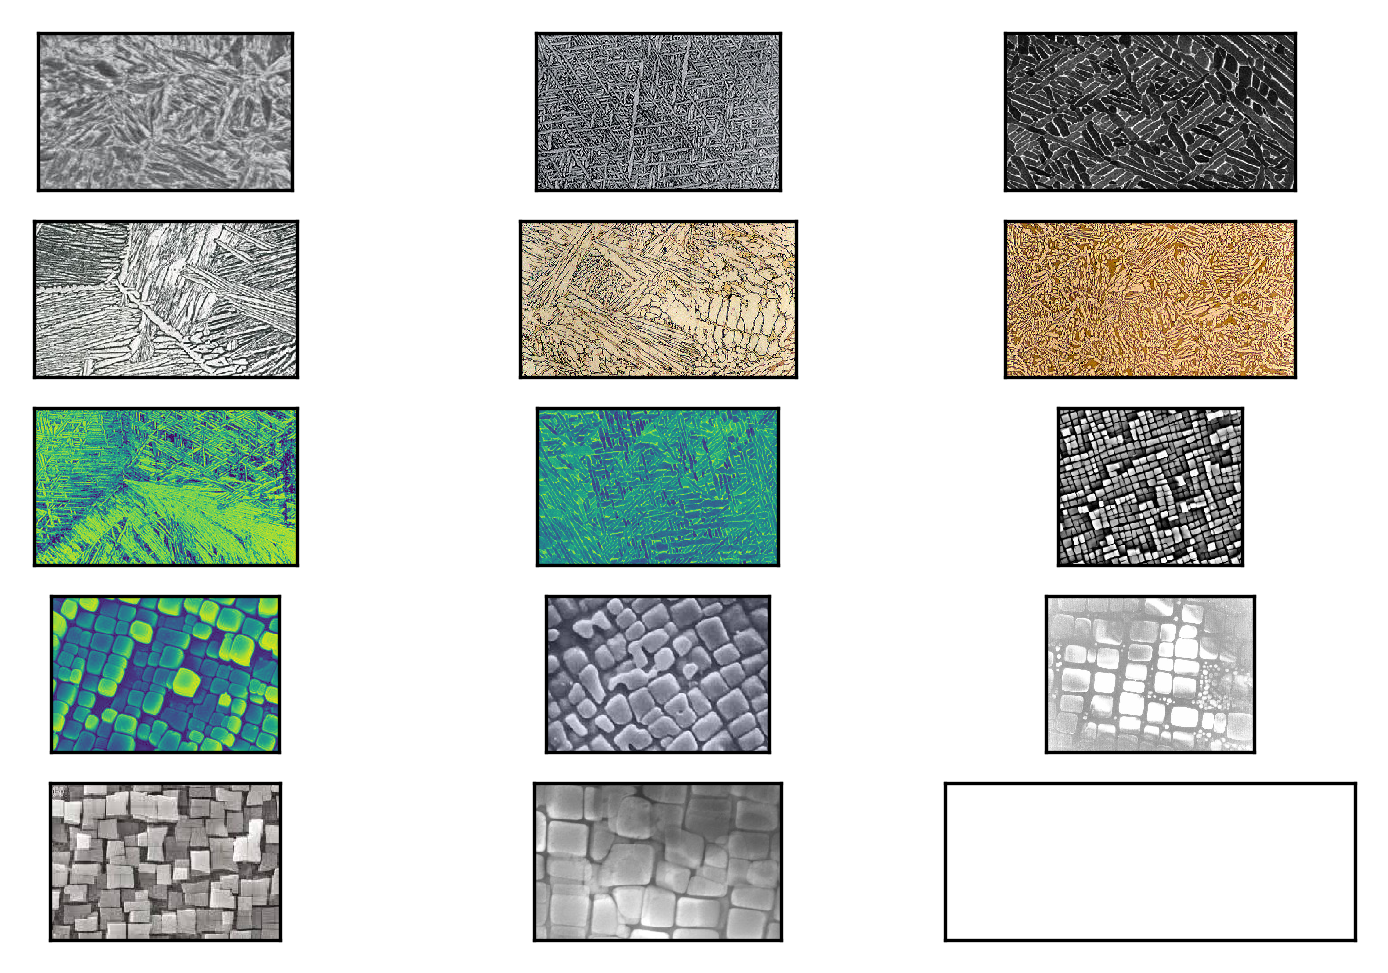

In [3]:
ncols = 3
nrows = 5
nimages = 14
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, dpi=300)
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
for i in range(nimages):
    img = mpimg.imread(files[i])
    axes[int((i-i%ncols)/ncols), i%ncols].imshow(img)

Notice that even though we are simplifiying our task by considering only a binary classification there is still quite a lot of variation in the images in terms of the image qualtity, the scale of the features, etc. This is still quite a challenging task.

## Step 2: Applying the SIFT descriptor
The SIFT descriptor is a method of describing features of interest in an image based on the local gradients of intensity at the feature. An important charcteristic of the SIFT descriptor is that it is invariant with scaling and rotation of an image. A common use for SIFT descriptors is tracking features between frames in a movie. 

The cell below applies feature detection and illustrates the sift descriptor for a sample image. Note that we always begin by making a greyscale version of the micrograph.

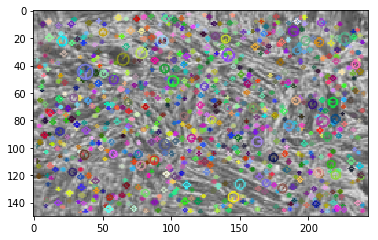

In [4]:
img = cv2.imread(files[0])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
img=cv2.drawKeypoints(gray,kp,img,flags=4)
plt.imshow(img)

The `detectAndCompute()` method of a `sift`object returns an array of SIFT descriptors for the image. Each descriptor consists of 128 numbers characterising the variation in intensity of the image around the feature. The `drawKeypoints()` method helpfully adds an indication of the postion and scale of the features to our image. Now let's examine the data returned for the image above.

In [5]:
print(type(kp), type(des))
print(np.shape(kp))
print(np.shape(des))

<class 'list'> <class 'numpy.ndarray'>
(995,)
(995, 128)


The `detectAndCompute()` method returns a list of the positions, sizes and orientations of the key points (the features), which we assign to the variable `kp` and an array of descriptors, which we assign to `des`. We can see that this image contains 995 features of interest.

Now lets use a `for` loop to generate descriptors for all of our training images:

In [6]:
features = []
pts = []
imgid = []
msid = []

for s in range(nfiles):
    img = cv2.imread(files[s])
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    for r in range(len(des)):
        features.append(des[r,:].tolist())

features = np.array(features)

Note that for our inital unsupervised clustering, all we care about is forming a huge list of all the features gathered from the training data. We do not care at this stage about which microstructures they come from. We can check how many descriptors we have to work with by looking at the size of the `features` array that we have built:

In [ ]:
print(np.shape(features))

## Step 3: Unsupervised learning to build the "bag of words"
Our next step is to carry out an unsupervised clustering of the array of descriptors to try to extract characteristic features that will form the "words". To do this we are going to use the k-means clustering algorithm that we started out this session by investigating. The choice of the number of clusters is the key parameter here and I had to play around with it a little before settling on a value of 30.

In [7]:
from sklearn.cluster import KMeans
nclusters = 30
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(features[:,:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The k-means clustering places the large number of SIFT descriptors extracted from our images into 30 clusters. The centres of these clusters define 30 "words", which each consist of 128 numbers (you could think of them as vectors in a 128-dimensional parameter space, if you wish).

Let's take a quick look at the first word in the dictionary:

In [8]:
print(kmeans.cluster_centers_[1,:])

[  19.43553009   24.87106017   42.04154728   33.35959885   17.78653295
   17.13753582   24.72922636   24.95415473   17.01146132   28.21633238
   50.34097421   49.03008596   32.33810888   25.79369628   27.2034384
   20.49283668   24.37249284   33.70200573   46.36389685   41.00573066
   26.11174785   23.20630372   26.72492837   22.44126074   25.31661891
   28.72492837   34.4226361    25.83524355   16.92406877   18.05014327
   21.5773639    24.67621777   21.13323782   30.5974212    67.40687679
   63.2277937    27.46275072   18.76504298   16.16045845   14.01719198
   97.81375358   42.05730659   46.19340974   36.9226361    18.96848138
   23.58022923   36.68338109   57.2965616    30.26934097   19.79512894
   23.99713467   33.00143266   56.55587393   74.94555874   57.69484241
   35.89541547   37.9025788    33.38395415   30.93696275   22.8008596
   22.76217765   25.17908309   29.97421203   38.85530086   24.31088825
   13.18481375   18.58595989   29.01289398   32.48710602   47.90544413
   57.47

This is not very informative, but you should get the general idea that we now have these lists of numbers (that we call visual "words") which we can use to describe microstructures.

## Step 4: Build the set of training images
## Step 5: Apply the image descriptor and clustering to the images
## Step 6: Build the "fingerprints" of the training images
The next three steps will all be performed at once. We define a loop to iterate over all the images in the training set. For each image, we hunt for features and calculate the SIFT descriptors for each (just as we did earlier). But now we have a trained k-means classifier that we use to assign each feature to one of the 30 words in our dictionary. We then count up the number of occurances of each word and normalise by the total count to give a histogram of words in each image that is our "fingerprint" of that image.

Let's take a look at the code:

In [9]:
# Set up arrays to hold the training inputs and outputs
trainx = np.zeros((nfiles,nclusters),dtype=float)
trainy = np.zeros(nfiles, dtype=int)

# Iterate over images in training set
for s in range(nfiles):
    features = []
    img = cv2.imread(files[s])
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)  # Detect features and calculate SIFT descriptors
    for r in range(len(des)):
        features.append(des[r,:].tolist())
    features = np.array(features)
    labels = kmeans.predict(features[:,:])     # Use k-means cluster model to assign features to clusters ("words")
    unique, counts = np.unique(labels, return_counts=True)
    # Build a histogram of occurences of words - the fingerprint of the image
    for t in range(len(unique)):
        trainx[s,unique[t]] = counts[t]
        trainy[s] = folderid[s]
    trainx[s,:] = trainx[s,:]/np.sum(trainx[s,:])

To help us understand what we have done, let's take a look at the fingerprint of the first image in our test set:

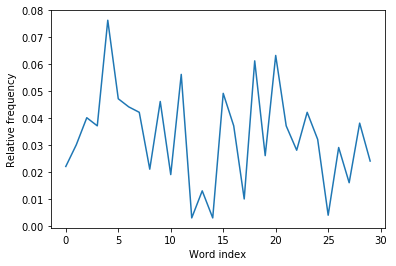

In [10]:
plt.plot(trainx[0,:])
plt.xlabel('Word index')
plt.ylabel('Relative frequency')

It's a little tricky to see how this random looking plot might encode details of the microstructure. Let's compare the fingerprints for all the training images and see if there are obvious differences between the two types of microstructure that we are studying. 

At the moment, the words in the fingerprint are in a random order. To make this comparison between microstructures clearer, we will reorder the words so that ones that are more common in the superalloy microstructure are early in the list and those that are more common in the basket-weave microstructure are near the end. We can get python to work out this ordering. (See if you can understand what this code is doing, but don't worry if not as it is just to help with viusalising what is going on and is not part of the machine learning process.)

In [11]:
orderscore = np.sum(trainx[:ninfolder[0]-ntest[0],:],axis=0) - np.sum(trainx[ninfolder[0]-ntest[0]:ninfolder[0]-ntest[0]+ninfolder[1]-ntest[1],:],axis=0)
orderid = np.argsort(orderscore)

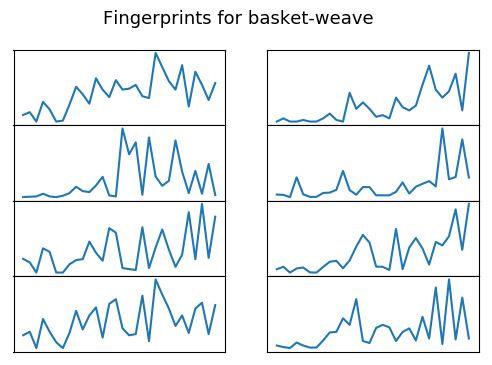

In [12]:
ncols = 2
nrows = 4
nplots = 8
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, dpi=100)
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
for i in range(nplots):
    #print(int((i-i%ncols)/ncols), i%ncols,plotidx)
    axes[int((i-i%ncols)/ncols), i%ncols].plot(trainx[i,orderid])
    
fig.subplots_adjust(hspace=0)
fig.suptitle('Fingerprints for basket-weave', fontsize=13)
plt.show()


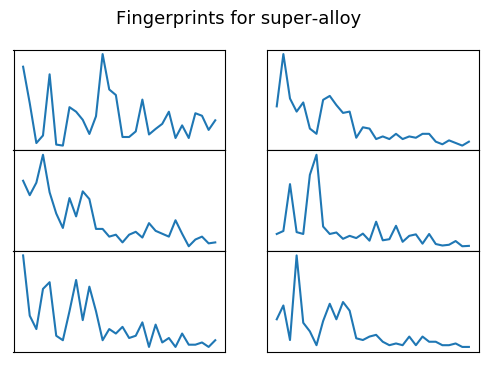

In [13]:
ncols = 2
nrows = 3
nplots = 6
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, dpi=100)
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
for i in range(nplots):
    #print(int((i-i%ncols)/ncols), i%ncols,plotidx)
    axes[int((i-i%ncols)/ncols), i%ncols].plot(trainx[i+8,orderid])
    
fig.subplots_adjust(hspace=0)
fig.suptitle('Fingerprints for super-alloy', fontsize=13)
plt.show()

There does seem to be some systematic difference in the fingerprints for the two microstructures, so there is hope that machine learning may be able to pick up on this.

## Step 7: Use supervised learning to train a SVM to classify fingerprints of images
We now use a *supervised learning* approach to train a classifier based on our training images. Once again, we will adopt an approach that we have already tried and use a support vector machine. The code to train this SVM is below. Once again, I needed to do a bit of fine tuning of the parameters `C` and `gamma`, but note how simple this is: essentially one line is needed to train the SVM.

In [14]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import chi2_kernel

svm = SVC(kernel=chi2_kernel, C=1.0, gamma=1.0).fit(trainx,trainy)

## Step 8: Test performance of SVM classifier on set of unseen test images
All that remains now is to test the SVM classifier on our unseen images. To do this, we need to load the images, determine the SIFT descriptors for the features in the images. Use the trained k-means clustering (from our unsupervised learning) to assign words to the desriptors, count the occurences of the words to build the fingerprints of the images and then use the trained SVM (from our supervised learning) to predict the microstructure of the image. Let's do this now:

In [15]:
testx = np.zeros((ntestfiles,nclusters),dtype=float)
testy = np.zeros(ntestfiles, dtype=int)
predicty = np.zeros(ntestfiles, dtype=int)
for s in range(ntestfiles):
    features = []
    img = cv2.imread(testfiles[s])
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    for r in range(len(des)):
        features.append(des[r,:].tolist())
    features = np.array(features)
    labels = kmeans.predict(features[:,:])
    unique, counts = np.unique(labels, return_counts=True)
    for t in range(len(unique)):
        testx[s,unique[t]] = counts[t]
        testy[s] = testfolderid[s]
    testx[s,:] = testx[s,:]/np.sum(testx[s,:])
    # Predict here!!
    labels = svm.predict(testx)

How have we done? The code below loads and displays the test images labeled with the predicted microstructure type:

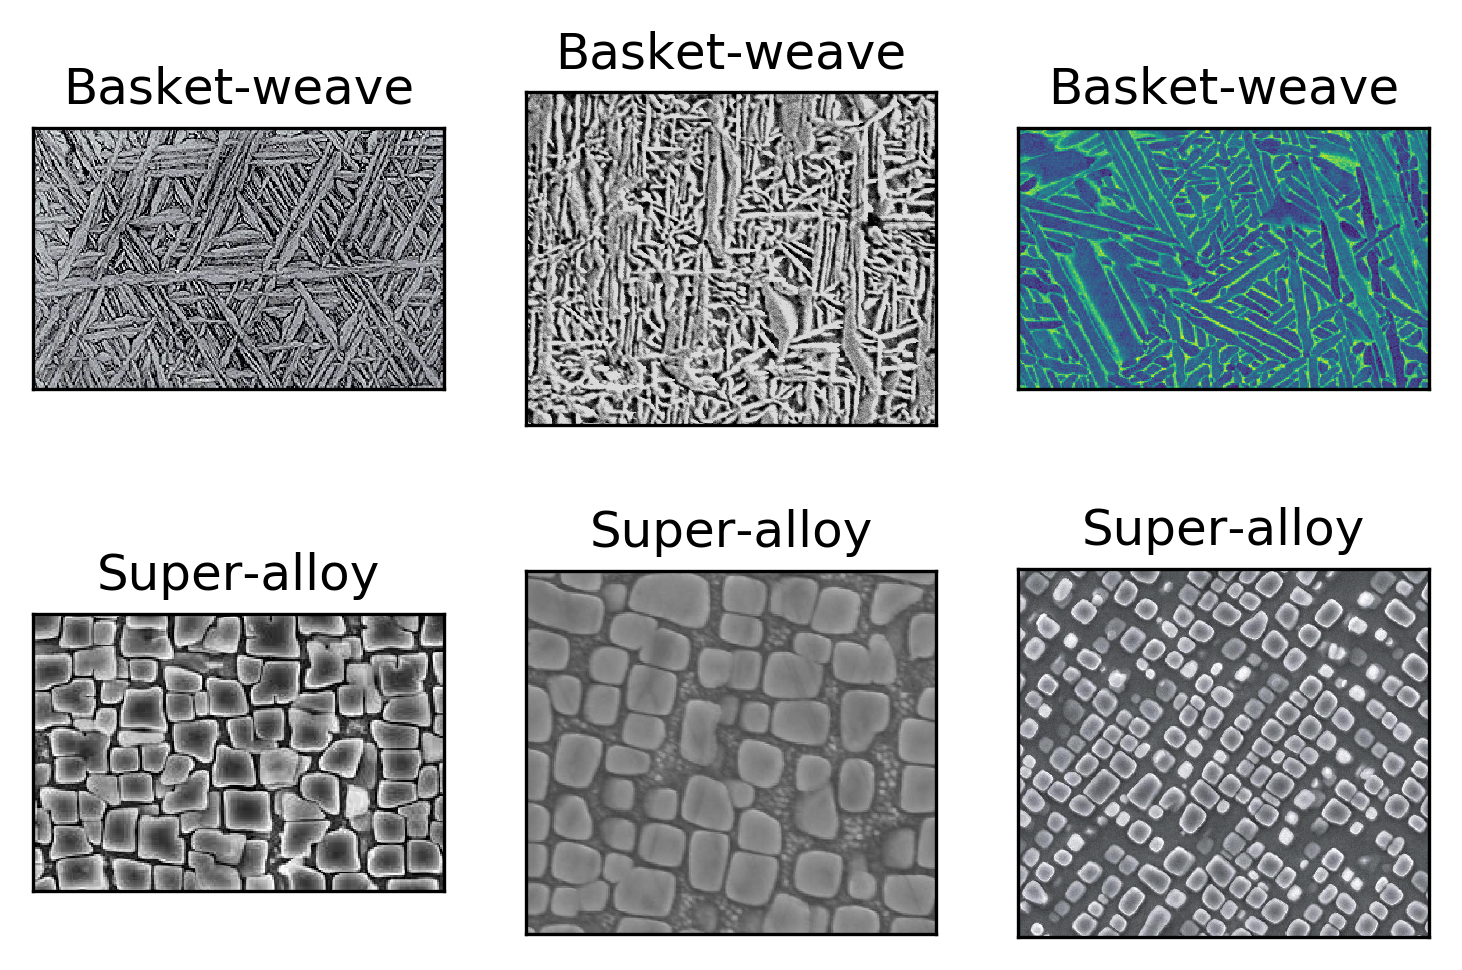

In [16]:
ncols = 3
nrows = 2
nimages = 6
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, dpi=300)
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
for i in range(nimages):
    img = mpimg.imread(testfiles[i])
    axes[int((i-i%ncols)/ncols), i%ncols].imshow(img)
    axes[int((i-i%ncols)/ncols), i%ncols].set_title("Basket-weave" if labels[i]==0 else "Super-alloy")

It looks like our classifier is working!